In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
import tensorflow

In [160]:
data = pd.read_csv('/content/Tesla_stock_prices.csv', parse_dates=True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/21/2017,69.164001,69.164001,66.370003,67.571999,67.571999,32477000
1,8/22/2017,68.225998,68.447998,67.473999,68.269997,68.269997,21610000
2,8/23/2017,67.797997,70.697998,67.660004,70.554001,70.554001,24772500
3,8/24/2017,70.503998,71.332001,69.947998,70.585999,70.585999,22923500
4,8/25/2017,70.848000,71.138000,69.459999,69.610001,69.610001,17420000


In [161]:
print(data.shape)

(1259, 7)


In [162]:
data[data.notnull()].count()

Date         1259
Open         1259
High         1259
Low          1259
Close        1259
Adj Close    1259
Volume       1259
dtype: int64

In [163]:
data_types = data.dtypes
data_types

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [164]:
#We want to look at the closing
new_data = data[['Date', 'Adj Close']]
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data = new_data.set_index('Date')
new_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Adj Close
Date,
2017-08-21,67.571999
2017-08-22,68.269997
2017-08-23,70.554001
2017-08-24,70.585999
2017-08-25,69.610001
...,...
2022-08-15,927.960022
2022-08-16,919.690002
2022-08-17,911.989990


Text(0, 0.5, 'Closing Price')

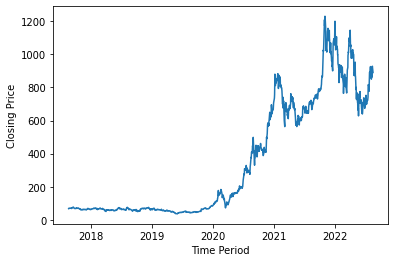

In [165]:
plt.plot(new_data)
plt.xlabel("Time Period")
plt.ylabel("Closing Price")


#### Exploratory Analysis

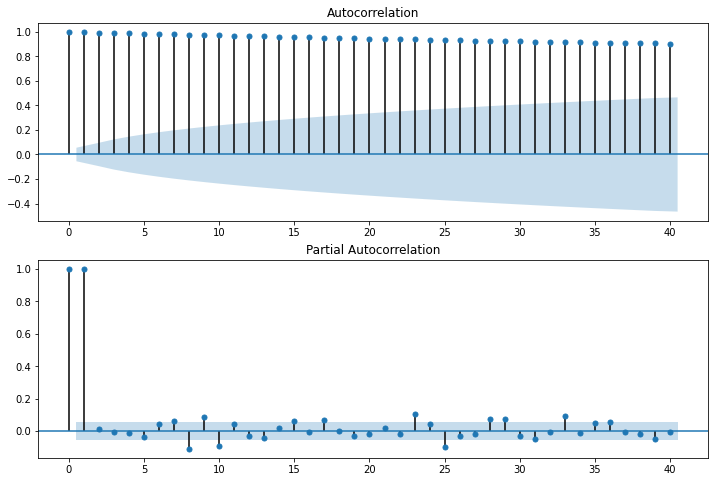

In [166]:

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_data['Adj Close'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_data['Adj Close'],lags=40,ax=ax2)

In [167]:
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(new_data['Adj Close'],autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                   -0.618653
p-value                           0.866711
#lags used                       18.000000
number of observations used    1240.000000
critical value (1%)              -3.435635
critical value (5%)              -2.863874
critical value (10%)             -2.568012
dtype: float64


Since our Test Statistic value > critical values at different percentages; hence, our data is non-stationary. We don't need to make the data stationary since LSTM can work on non-stationary data



```
# This is formatted as code
```

### Splitting Data

In [168]:
from sklearn.model_selection import train_test_split
import math

def train_validate_test_split(arr, train_len, valid_len, test_len):

  train_length  = math.ceil(len(arr) * train_len) 
  validate_length = math.ceil(len(arr) * (train_len + valid_len))  #Eg, Data from 70% to 80%

  print("Train length: {}, Validate length {}, Test length {}".format(math.ceil(train_length), math.ceil(validate_length), math.floor(test_length)))

  train_data = arr[: train_length]
  validate_data = arr[train_length: validate_length]
  test_data = arr[validate_length:]

  return train_data, validate_data, test_data

Train length: 882, Validate length 1008, Test length 252


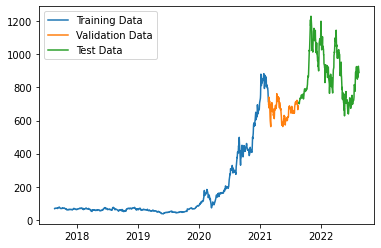

In [169]:
train_data, validate_data, test_data = train_validate_test_split(new_data, 0.7, 0.1, 0.2)



plt.plot(train_data, label = "Training Data")
plt.plot(validate_data, label = 'Validation Data')
plt.plot(test_data, label = "Test Data")
plt.legend()

### Preprocessing

In [170]:
# Normalize data b/w 0-1

from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))
train_scaled = scalar.fit_transform(train_data['Adj Close'].values.reshape(-1,1))
validate_scaled = scalar.fit_transform(validate_data['Adj Close'].values.reshape(-1,1))
test_scaled = scalar.fit_transform(test_data['Adj Close'].values.reshape(-1,1))

In [174]:
from keras.preprocessing.sequence import TimeseriesGenerator
# Use first 7 values to predict the 8th value
n_input = 7

train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=7, batch_size=1)
valid_generator = TimeseriesGenerator(validate_scaled, validate_scaled, length = 7, batch_size=1)
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length = 7, batch_size = 1)


print("Total number of batches:", len(train_generator))

#Using the first 7 values, we predict the 8th value
i = 0
for i in range(len(train_generator)):
  if i == 10:
    break
  else:
    X,y = train_generator[i]
    print("Input values of first generator:", X.flatten())
    print("Predicted value: ", y)
    i +=1 


Total number of batches: 875
Input values of first generator: [0.03750519 0.03832899 0.04102463 0.04106239 0.03991049 0.03934635
 0.03974762]
Predicted value:  [[0.0411214]]
Input values of first generator: [0.03832899 0.04102463 0.04106239 0.03991049 0.03934635 0.03974762
 0.0411214 ]
Predicted value:  [[0.04176344]]
Input values of first generator: [0.04102463 0.04106239 0.03991049 0.03934635 0.03974762 0.0411214
 0.04176344]
Predicted value:  [[0.04164542]]
Input values of first generator: [0.04106239 0.03991049 0.03934635 0.03974762 0.0411214  0.04176344
 0.04164542]
Predicted value:  [[0.040274]]
Input values of first generator: [0.03991049 0.03934635 0.03974762 0.0411214  0.04176344 0.04164542
 0.040274  ]
Predicted value:  [[0.03907961]]
Input values of first generator: [0.03934635 0.03974762 0.0411214  0.04176344 0.04164542 0.040274
 0.03907961]
Predicted value:  [[0.04051477]]
Input values of first generator: [0.03974762 0.0411214  0.04176344 0.04164542 0.040274   0.03907961
 

In [175]:
X.shape, y.shape

((1, 7, 1), (1, 1))

### Model Design

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError


model = Sequential([layers.Input((7, 1)),
                    layers.LSTM(64),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1, activation = 'linear')])

model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


In [177]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'mse',
    metrics=['mean_absolute_error'],
)


### Model Train

In [178]:
model.fit(train_generator, validation_data=valid_generator, epochs = 30)

Epoch 1/30
875/875 [==============================] - 8s 7ms/step - loss: 0.0052 - mean_absolute_error: 0.0343 - val_loss: 0.0318 - val_mean_absolute_error: 0.1409
Epoch 2/30
875/875 [==============================] - 4s 5ms/step - loss: 0.0012 - mean_absolute_error: 0.0201 - val_loss: 0.0226 - val_mean_absolute_error: 0.1161
Epoch 3/30
875/875 [==============================] - 4s 5ms/step - loss: 0.0010 - mean_absolute_error: 0.0196 - val_loss: 0.0214 - val_mean_absolute_error: 0.1135
Epoch 4/30
875/875 [==============================] - 4s 5ms/step - loss: 0.0012 - mean_absolute_error: 0.0209 - val_loss: 0.0217 - val_mean_absolute_error: 0.1138
Epoch 5/30
875/875 [==============================] - 4s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0223 - val_loss: 0.0199 - val_mean_absolute_error: 0.1083
Epoch 6/30
875/875 [==============================] - 4s 5ms/step - loss: 0.0012 - mean_absolute_error: 0.0207 - val_loss: 0.0170 - val_mean_absolute_error: 0.0987
Epoch 7/30
875/8

### Results<br><br>

####**Absolute Error**

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


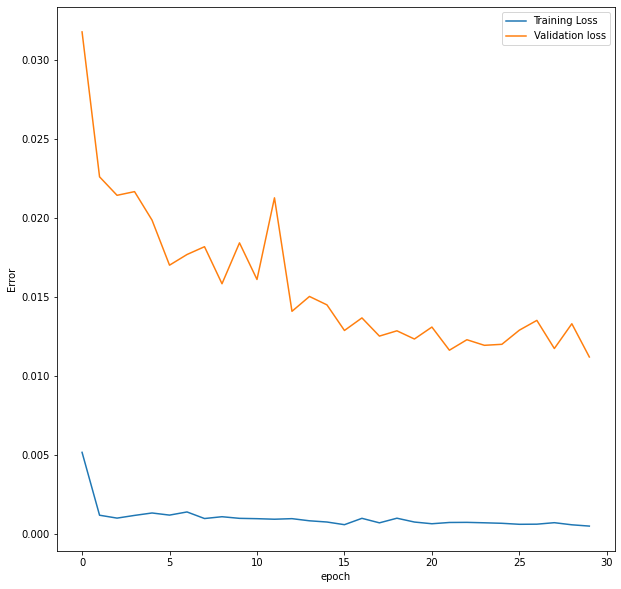

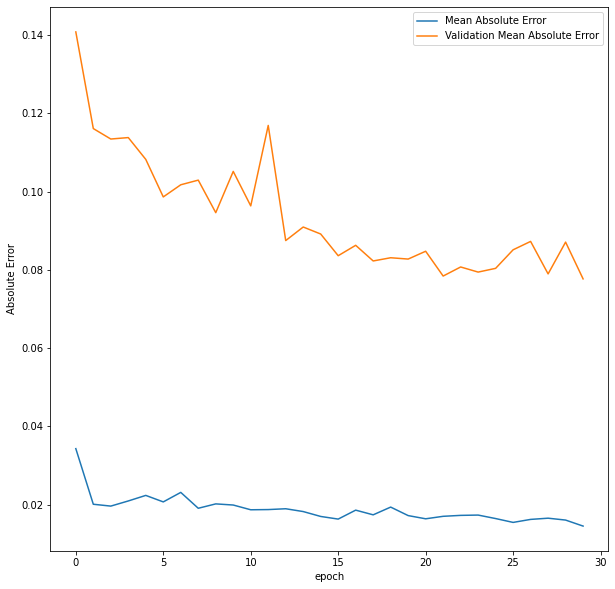

In [179]:
# list all data in history
print(model.history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(10,10))
plt.plot(model.history.history['loss'], label = 'Training Loss')
plt.plot(model.history.history['val_loss'], label = 'Validation loss')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.figure(figsize=(10,10))
plt.plot(model.history.history['mean_absolute_error'], label = 'Mean Absolute Error')
plt.plot(model.history.history['val_mean_absolute_error'], label = 'Validation Mean Absolute Error')
plt.ylabel('Absolute Error')
plt.xlabel('epoch')
plt.legend()
plt.show()



The reason behind having such a difference between training loss and validation loss is because we took a large amount of training data when the stock prices weren't rising a lot (2018 - 2021) as shown below. However, we took validation data when the stock prices started to rise (orange line). Hence, the data on which the model is trained is very different than the data on which the model will be validated or tested. To improve the model, we should take data starting in 2020. <br><br>

However, it won't still improve the results a lot since we have very limited data and we're looking at daily stocks. If we want to see better results and better prediction, we should take a higher range of values such as monthly prediction

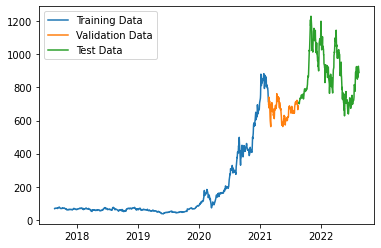

In [180]:
plt.plot(train_data, label = "Training Data")
plt.plot(validate_data, label = 'Validation Data')
plt.plot(test_data, label = "Test Data")
plt.legend()

####**Prediction - Training Data**

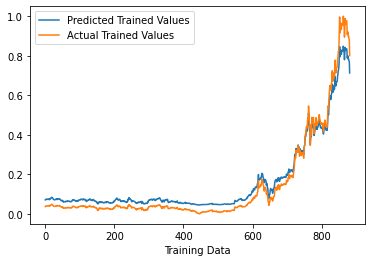

In [122]:
#However, we will still show that our model does well for predicting training data
train_prediction = model.predict(train_scaled)

#Actual vs Prediction for trained data
plt.plot(train_prediction, label = "Predicted Trained Values")
plt.plot(train_scaled, label = "Actual Trained Values")
plt.xlabel("Training Data")
plt.legend()

####**Prediction - Validation Data**

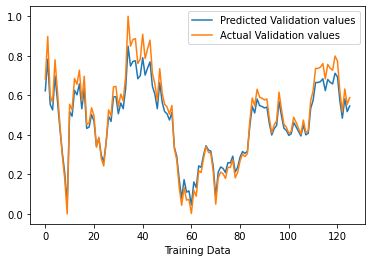

In [123]:
validate_prediction = model.predict(validate_scaled)

#Actual vs Prediction for trained data
plt.plot(validate_prediction, label = "Predicted Validation values")
plt.plot(validate_scaled, label = "Actual Validation values")
plt.xlabel("Training Data")

plt.legend()

####**Prediction - Test Data**

Here we provide the model with test data already. We can see then it provides us prediction that are close to test data.

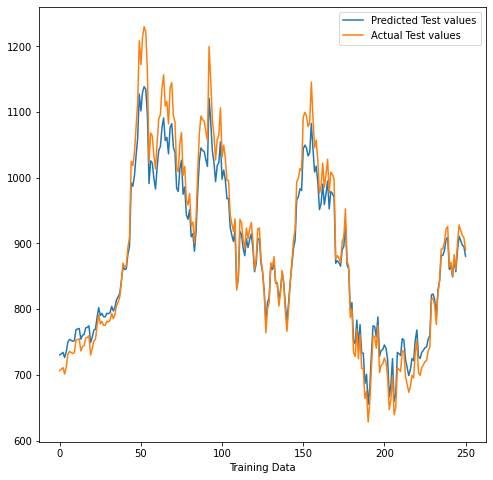

In [151]:
test_prediction = model.predict(test_scaled)
#Convert predicted results to original scale
test_predicition_orginalscale = scalar.inverse_transform(test_prediction)
test_predicition_orginalscale = pd.DataFrame(test_predicition_orginalscale, columns=['Prediction Results'])
test_predicition_orginalscale


Test_data = data['Adj Close'][1008:]
Test_data.index = range(251)
Test_data

plt.figure(figsize=(8,8))
plt.plot(test_predicition_orginalscale, label = "Predicted Test values")
plt.plot(Test_data, label = "Actual Test values")
plt.xlabel("Training Data")
plt.legend(loc='upper right')








####**Future Prediction**
We provide our model with the last 7 values (input values) of our validation data. Using those values, we want to see how well our model predicts the 8th value (this is the 1st value of the test data). Then we recursively provide the last 7 values for our model to predict the 8th value.

In [152]:
#Predicted test value
last_train_batch = validate_scaled[-7:]
last_train_batch = last_train_batch.reshape((1, 7, 1))
model.predict(last_train_batch)




array([[0.5989407]], dtype=float32)

In [181]:
#Actual test value
test_scaled[0]


array([0.1298546])

In [182]:
test_predictions_2 = []

first_eval_batch = validate_scaled[-7:]
current_batch = first_eval_batch.reshape((1, 7, 1))

for i in range(len(test_scaled)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_2.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



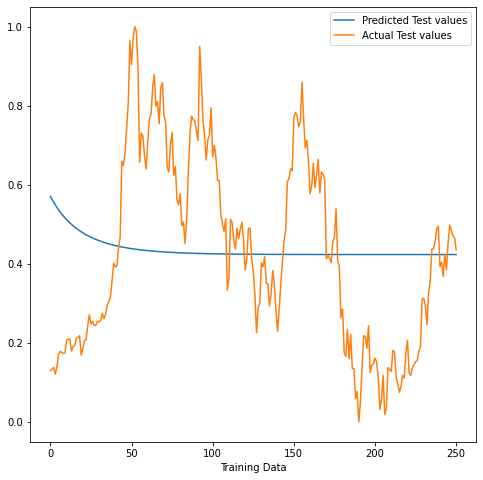

In [183]:
plt.figure(figsize=(8,8))
plt.plot(test_predictions_2, label = "Predicted Test values")
plt.plot(test_scaled, label = "Actual Test values")
plt.xlabel("Training Data")
plt.legend(loc='upper right')

## Stock Prediction using FB Prophet